# Task 1, 3 - fastai interface for tabular data

In [1]:
# !pip install fastinference fastai

In [12]:
from fastai.tabular.all import *

We have a look at the adult tabular sample. Let's unpack these:

In [3]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [4]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing]
# procs = [Categorify, FillMissing, Normalize]

In [5]:
splits = IndexSplitter(list(range(800,1000)))(range_of(df))
to = TabularPandas(df, procs, cat_names, cont_names, y_names="salary", splits=splits)
dls = to.dataloaders()

In [6]:
splits

((#32361) [0,1,2,3,4,5,6,7,8,9...],
 (#200) [800,801,802,803,804,805,806,807,808,809...])

We can now create the Learner to create this tabular model. As usual, we use the application-specific learner function, to take advantage of its application-customized defaults.

By default, for tabular data fastai creates a neural network with two hidden layers, with 200 and 100 activations, respectively. This works quite well for small datasets, but if we had a larger dataset, we can increase the layer sizes.


In [7]:
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.376055,0.361244,0.825000,00:04


Now we can make a `test_dl` to work with our `get_preds` too, let's have a look:

In [8]:
test_dl = learn.dls.test_dl(df.iloc[:3])

In [9]:
preds = learn.get_preds(dl=test_dl,with_decoded=True)

So first we have our classes and probabilities again. where class 0 - <50k and class 1 >=50k

In [10]:
preds

(tensor([[0.5107, 0.4893],
         [0.4742, 0.5258],
         [0.9740, 0.0260]]),
 tensor([[1],
         [1],
         [0]], dtype=torch.int8),
 tensor([0, 1, 0]))

## Task 5 - Export to ONNX and compare inference

In [11]:
from fastinference.onnx import *
from challenge.functions import *

ONNX is a special module, where we can potentially speed up inference by relying on C++ rather than Python, but it's not easy to export from fastai, but with `fastinference.onnx` it should work out well! 
All we need to do is call `learn.to_onnx` and pass in a fname to export to both the ONNX format and export our model.

In [13]:
learn.to_onnx(path/'models/tabular')

Let's load our model as a fastONNX model:

In [14]:
tab_inf = fastONNX(str(path)+'/models/tabular')

Let's compare how the two different predict methods stack up. First, fastai:

In [19]:
%%time
_ = learn.predict(df.iloc[0])

CPU times: user 53.7 ms, sys: 4.41 ms, total: 58.1 ms
Wall time: 52.3 ms


And now ONNX version. We pass a raw batch of data to our model, so let's grab the first batch and predict:

In [20]:
test_dl.bs = 1
batch = next(iter(test_dl))

In [21]:
%%timeit
_ = tab_inf.predict(batch[:2])

158 µs ± 1.37 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


That's fast! So we can use fastai to learn tabular data and run inferences on the model-agnostic ONNX. What else can fastai do?

# Task 2 - Further tabular analysis

In [22]:
from fastinference.tabular import *

We can use fastinference to run SHAP interpretations.

SHAP builds model explanations by asking the same question for every prediction and feature: “How does prediction i change when feature j is removed from the model?” So-called SHAP values are the answers. They quantify the magnitude and direction (positive or negative) of a feature’s effect on a prediction.

In [29]:
exp = ShapInterpretation(learn, df.iloc[:1000])

Classification model detected, displaying score for the class >=50k.
(use `class_id` to specify another class)
Displaying row 1 of 1000 (use `row_idx` to specify another row)


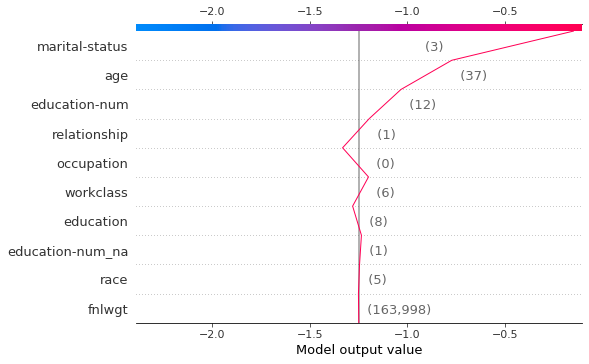

In [31]:
exp.decision_plot(class_id=">=50k",row_idx=1) # classID 1

The above decision plot’s straight vertical line marks the model’s base value. The colored line is the prediction. Feature values are printed next to the prediction line for reference. Starting at the bottom of the plot, the prediction line shows how the SHAP values (i.e., the feature effects) accumulate from the base value to arrive at the model’s final score at the top of the plot. (Roughly speaking, this is similar to a statistical linear model where the sum of effects, plus an intercept, equals the prediction.) Decision plots are literal representation of SHAP values, making them easy to interpret.

Similarly, this can be expressed in a waterfall plot below.

Classification model detected, displaying score for the class >=50k.
(use `class_id` to specify another class)
Displaying row 1 of 1000 (use `row_idx` to specify another row)


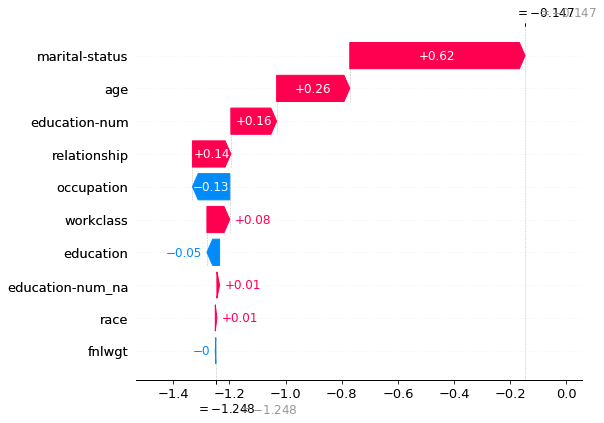

In [32]:
exp.waterfall_plot(row_idx=1, class_id='>=50k')

Classification model detected, displaying score for the class >=50k.
(use `class_id` to specify another class)


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


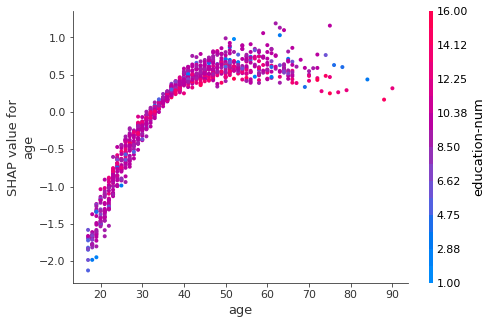

In [33]:
exp.dependence_plot('age', interaction_index='education-num',class_id=1)

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. In this example the log-odds of making over 50k increases significantly between age 20 and 40.

Each dot is a single prediction (row) from the dataset.

The x-axis is the value of the feature (from the X matrix).

The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction.

The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (by default this second feature is chosen automatically). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring. For the example above 20-year-olds with a high level of education are less likely make over 50k than 20-year-olds with a low level of education. This suggests an interaction effect between Education-Num and Age.
`

In [27]:
exp.force_plot(class_id=1)

Classification model detected, displaying score for the class >=50k.
(use `class_id` to specify another class)


For comparison, a multi-prediction force plot is shown above. It is a combination of many individual force plots that are rotated 90 degrees and stacked horizontally. There are several differences between the plots; we will point out a few.

The force plot shows that approximately three-quarters of the predictions follow the prediction path dominated by marital status. The decision plot cannot convey this sense of proportion. In the force plot, it is not evident that the predictions on the left are dominated by marital status unless it is viewed in interactive mode where feature labels appear on mouse-over. Furthermore, the general patterns for age and relationship do not stand out. The decision plot reveals these aspects more effectively.

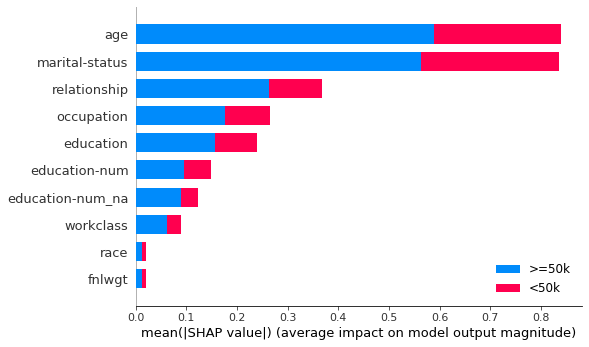

In [28]:
exp.summary_plot()